## Imports

In [ ]:
import os
import sys
import re
import csv
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report

from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage import feature
from skimage import filters

from scipy import ndimage as ndi

## Load image paths from google drive. To use the local files, change `google_path` to `.`

In [ ]:
def get_image_mask_pairs(subjects, rgb_path, mask_path):
    '''
    Match images with labels in the csv file.
    '''
    images = []
    masks = []
    for patient in subjects:
        for file in os.listdir(rgb_path):
            if re.match(patient[0], file):
                images.append(os.path.join(rgb_path, file))
                masks.append(os.path.join(mask_path, file))
    return images, masks

In [ ]:
google_path = '/content/drive/MyDrive'
path = os.path.join(google_path, 'QC')
train_test_path = os.path.join(path, 'split')
mask_path = os.path.join(path, "mask")
rgb_path = os.path.join(path, "rgb")

# Load training and validation csv files
def load_subjects(csv_path):
    with open(csv_path, newline='') as f:
        reader = csv.reader(f)
        subjects = list(reader)
    return subjects[1:]

train_subjects = load_subjects(os.path.join(train_test_path, 'train_subjects.csv'))
val_subjects = load_subjects(os.path.join(train_test_path, 'validate_subjects.csv'))

train_images, train_masks = get_image_mask_pairs(train_subjects, rgb_path, mask_path)
val_images,   val_masks   = get_image_mask_pairs(val_subjects, rgb_path, mask_path)

# 4. Segmentation

## Load images and masks and make transformations

In [ ]:
def get_neighbourhood(img, coord, k):
    '''
    Return (k x k) neighbourhood centred at specified image coordinate.
    Assumes k is odd.
    Perform zero padding at image border.
    '''
    if k == 0:
        return img[*coord]

    out = np.zeros((k, k))
    img = np.pad(img, k//2, mode='constant', constant_values=0)

    for i in range(-k//2, k//2+1):
        for j in range(-k//2, k//2+1):
            out[i + k//2, j + k//2] = img[coord[0] + k//2 + i, coord[1] + k//2 + j]
    return out


def canny(img):
    '''
    Return filtered images obtained with Canny dege filter.
    '''
    feats = dict()
    for sigma in [1, 2]:
        feats[f'canny_{sigma}'] = feature.canny(img, sigma)
    return feats

def local_binary_pattern(img):
    '''
    Return filtered images obtained with local binary pattern filter.
    '''
    feats = dict()
    for radius in [1, 2, 3]:
        feats[f'local_binary_pattern_{radius}'] = feature.local_binary_pattern(img, P=8*radius, R=radius)
    return feats

def entropy(img):
    '''
    Return filtered images obtained with local entropy filter.
    '''
    feats = dict()
    for radius in [3, 5, 7]:
        feats[f'entropy_{radius}'] = filters.rank.entropy(img, disk(radius))
    return feats

def gabor(img):
    '''
    Return filtered images obtained with a Gabor filter bank.
    Gabor filters are similar to the early layers of CNNs.
    Reference: https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_gabor.html
    '''
    kernels = []
    for theta in range(4):
        theta = theta / 4.0 * np.pi
        for sigma in (1, 3):
            for frequency in (0.05, 0.25):
                kernel = np.real(
                    filters.gabor_kernel(frequency, theta=theta, sigma_x=sigma, sigma_y=sigma)
                )
                kernels.append(kernel)

    feats = dict()
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(img, kernel, mode='constant', cval=0)
        feats[f"gabor_{k}"] = filtered

    return feats

def gaussian(img):
    '''
    Return filtered images obtained with a Gaussian filter bank.
    '''
    feats = dict()
    for sigma in [3, 5, 7]:
        feats[f"gaussian_{sigma}"] = filters.gaussian(img, sigma)

    return feats

def extract_SVM_features(img, mask, feature_toggle, k=3, p=0.001, infer=False):
    '''
    Given image, randomly sample a portion of image pixels (p) and extract associated features and labels.
    If performing inference, features are extracted for every coordinate.
    '''
    assert img.shape == mask.shape, "Image and mask have different shape!"

    # Construct features
    features = dict()
    features['original'] = img
    features.update(canny(img))
    features.update(local_binary_pattern(img))
    features.update(entropy(img))
    features.update(gabor(img))
    features.update(gaussian(img))

    # Normalize features to encourage better learning and faster convergence
    for key, value in features.items():
        if np.std(value) == 0:
            print(key)
        features[key] = (value - np.mean(value)) / np.std(value)

    # Collect coordinates
    if infer:
        ii = np.arange(img.shape[0])
        jj = np.arange(img.shape[1])
        I, J = np.meshgrid(ii, jj)
        coordinates = [(i,j) for i,j in zip(I.flatten(), J.flatten())]
    else:
        coordinates = [(i,j) for i,j in zip(np.random.randint(0, img.shape[0], size=int(p*img.size)),
                                        np.random.randint(0, img.shape[1], size=int(p*img.size)))]

    # Retrieve features for each coordinate
    _X, _Y = [], []
    for coord in coordinates:
        f = []
        l = mask[*coord]

        for feat_name, feat in features.items():
            if feat_name.split('_')[0] in feature_toggle:
                f.append(get_neighbourhood(feat, coord, k).flatten())

        f = np.concatenate(f)  # join all features

        _X.append(f)
        _Y.append(l)

    return _X, _Y

def extract_features_labels(images, masks, target_size=None, **kwargs):
    '''
    Build feature and label lists.
    '''
    X, Y = [], []
    for img_path, mask_path in zip(images, masks):

        # Load image, resize if desired
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        if not(target_size is None):
            img = cv.resize(img, target_size)

        # Load mask, resize if desired
        mask = cv.imread(mask_path, cv.IMREAD_COLOR)
        mask = mask[:, :, 0]  # first channel encodes class labels
        if not(target_size is None):
            mask = cv.resize(mask, target_size)

        mask = mask > 2
        mask = mask.astype(int)

        # Extract features
        _X, _Y = extract_SVM_features(img, mask, **kwargs)

        X += _X
        Y += _Y

    return np.array(X), np.array(Y)

## Define class weight

Compute distribution of class labels

In [ ]:
labels = []

for path in train_masks:
    mask = cv.imread(path, cv.IMREAD_COLOR)
    mask = mask[:, :, 0]
    labels += [*mask.flatten()]

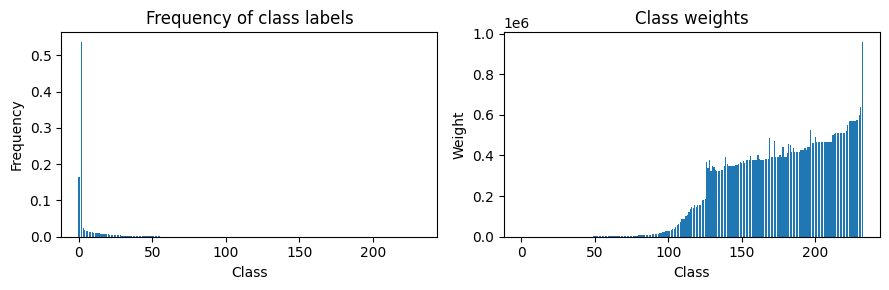

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3))
unique, counts = np.unique(labels, return_counts=True)

counts = counts / np.sum(counts)
class_weight = 1 / counts

CLASS_WEIGHT = {c:w for c,w in zip(unique, class_weight)}

ax[0].set_title("Frequency of class labels")
ax[0].set_xlabel("Class")
ax[0].set_ylabel("Frequency")
ax[0].bar(unique, counts)

ax[1].set_title("Class weights")
ax[1].set_xlabel("Class")
ax[1].set_ylabel("Weight")
ax[1].bar(unique, class_weight)

fig.tight_layout()

## Train support vector machine

Generally, as the number of features grows, there becomes less of a need to map features to higher dimensional space, and a linear SVM can be sufficient.<br>
This is the case for us, as each pixel is associated with hundreds of features.

In [ ]:
class CONST:
    target_size: tuple = (64, 64)
    nbhd_width: int = 3
    data_fraction: float = 1e-2

feature_toggle = ['original', 'canny', 'local_binary_pattern', 'entropy', 'gabor', 'gaussian']

x_train, y_train = extract_features_labels(train_images, train_masks, feature_toggle=feature_toggle, target_size=CONST.target_size, k=CONST.nbhd_width, p=CONST.data_fraction)
x_val,   y_val   = extract_features_labels(val_images,   val_masks,   feature_toggle=feature_toggle, target_size=CONST.target_size, k=CONST.nbhd_width, p=CONST.data_fraction)

model = LinearSVC(class_weight='balanced', max_iter=3000)
model = model.fit(x_train, y_train)

Accuracy: 0.7960880195599022


<BarContainer object of 2 artists>

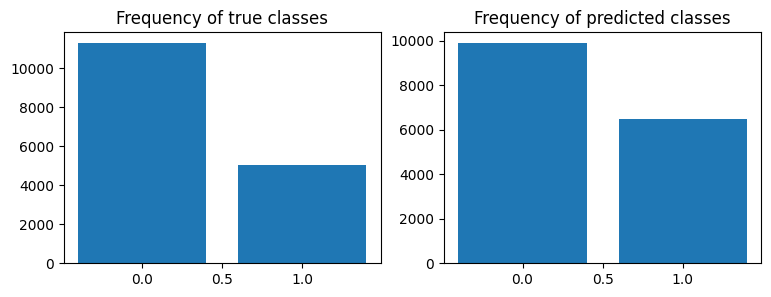

In [ ]:
y_pred = model.predict(x_val)

accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy}")
fig, ax = plt.subplots(1, 2, figsize=(9, 3))

u1, c1 = np.unique(y_val, return_counts=True)
u2, c2 = np.unique(y_pred, return_counts=True)

ax[0].set_title("Frequency of true classes")
ax[0].bar(u1, c1)
ax[1].set_title("Frequency of predicted classes")
ax[1].bar(u2, c2)

## Run inference using trained model

In [ ]:
def segment(img, mask, model, target_size, k):
    X, Y = extract_features_labels([img], [mask], target_size=target_size, feature_toggle=feature_toggle, k=k, infer=True)
    Y_pred = model.predict(X)
    return X, Y, Y_pred

In [ ]:
feature_toggle = ['original', 'canny', 'local_binary_pattern', 'entropy', 'gabor', 'gaussian']

ind = 0

img_path = val_images[ind]
mask_path = val_masks[ind]

img = cv.imread(img_path)
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img = cv.resize(img, CONST.target_size)

X, Y, Y_pred = segment(img_path, mask_path, model, CONST.target_size, CONST.nbhd_width)

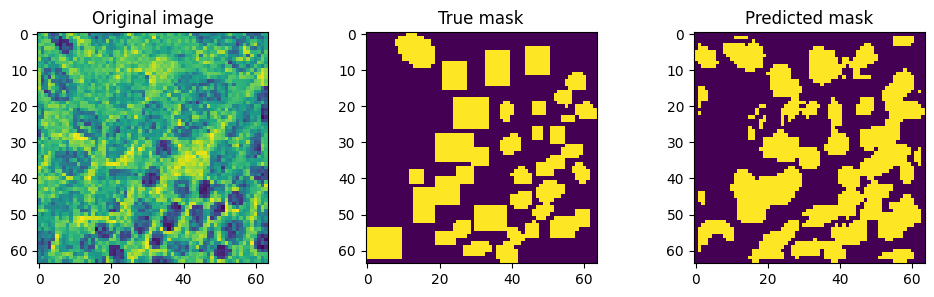

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

ax[0].set_title("Original image")
ax[0].imshow(img)

ax[1].set_title("True mask")
ax[1].imshow(Y.reshape(CONST.target_size))

ax[2].set_title("Predicted mask")
ax[2].imshow(Y_pred.reshape(CONST.target_size))

DICE Score - Training: 0.6841
DICE Score - Testing : 0.7039


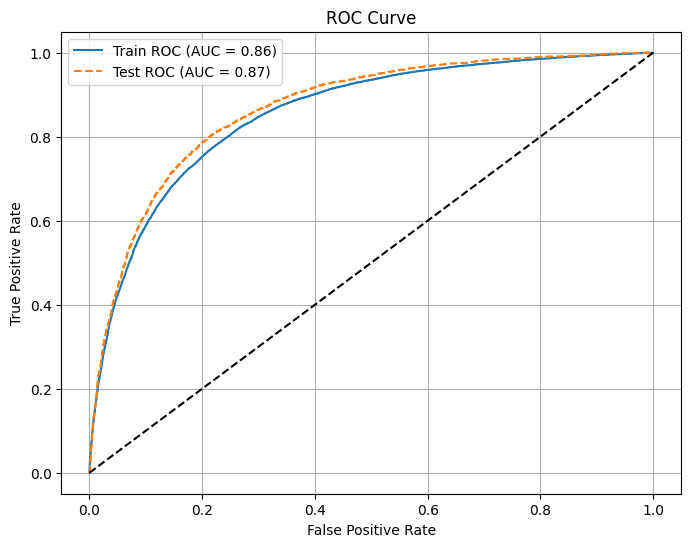

In [ ]:
from sklearn.metrics import f1_score, roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

# Predict on both train and test (val) sets
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_val)

# DICE score (F1 score for binary classification)
dice_train = f1_score(y_train, y_train_pred)
dice_test = f1_score(y_val, y_test_pred)

print(f"DICE Score - Training: {dice_train:.4f}")
print(f"DICE Score - Testing : {dice_test:.4f}")

# ROC Curve & AUC (need decision_function or predict_proba)
if hasattr(model, "decision_function"):
    y_train_score = model.decision_function(x_train)
    y_test_score = model.decision_function(x_val)
else:
    y_train_score = model.predict_proba(x_train)[:, 1]
    y_test_score = model.predict_proba(x_val)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_score)
fpr_test, tpr_test, _ = roc_curve(y_val, y_test_score)
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {auc_train:.2f})")
plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {auc_test:.2f})", linestyle='--')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


## Experimentation

In [ ]:
img = cv.imread(train_images[0])
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
entropy(img)
out, hog_img = feature.hog(img, visualize=True)

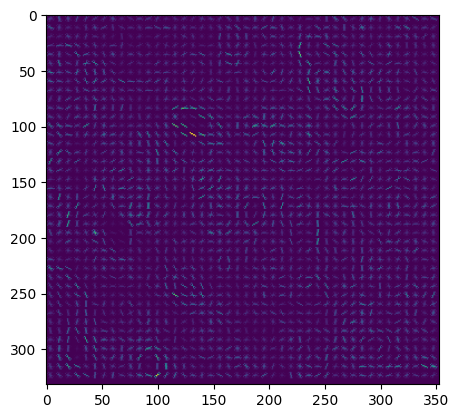

In [ ]:
plt.imshow(hog_img)